In [107]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dython
from optuna import trial
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import xgboost
import plotly.express as px

In [101]:
path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")
src = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))
src.rename(columns={
    'Number_of_Riders': 'Riders',
    'Number_of_Drivers': 'Drivers',
    'Location_Category': 'Location',
    'Customer_Loyalty_Status': 'Loyalty',
    'Number_of_Past_Rides': 'PastRides',
    'Average_Ratings': 'Ratings',
    'Time_of_Booking': 'BookingTime',
    'Vehicle_Type': 'Vehicle',
    'Expected_Ride_Duration': 'Duration',
    'Historical_Cost_of_Ride': 'Cost'
}, inplace=True)

In [102]:
print(f"Dataset info:\n"
      f"shape: \n{src.shape}\n"
      f"null values: \n{src.isnull().sum()}\n"
      f"dtypes: \n{src.dtypes}")


Dataset info:
shape: 
(1000, 10)
null values: 
Riders         0
Drivers        0
Location       0
Loyalty        0
PastRides      0
Ratings        0
BookingTime    0
Vehicle        0
Duration       0
Cost           0
dtype: int64
dtypes: 
Riders           int64
Drivers          int64
Location        object
Loyalty         object
PastRides        int64
Ratings        float64
BookingTime     object
Vehicle         object
Duration         int64
Cost           float64
dtype: object


OK, so 1000 entries, no null values. Good.
Let's create base model to have reference point.

In [111]:
encoder = LabelEncoder()
for cat in src[src.columns[src.dtypes == 'object']]:
    src[cat] = encoder.fit_transform(src[cat])

base_model = xgboost.XGBRegressor()
X = src.drop(columns=['Cost']).to_numpy()
y = src['Cost'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
base_score = base_model.score(X_test, y_test)
base_rmse = root_mean_squared_error(y_test, y_pred)
print("R squared: ",score)
print("RMSE:", base_rmse)
print('Feature importances', base_model.feature_importances_)

R squared:  0.8376721994853837
RMSE: 76.93245052536675
Feature importances [0.0125473  0.0191822  0.0185546  0.01791503 0.0205535  0.02504001
 0.01698378 0.06614096 0.8030826 ]


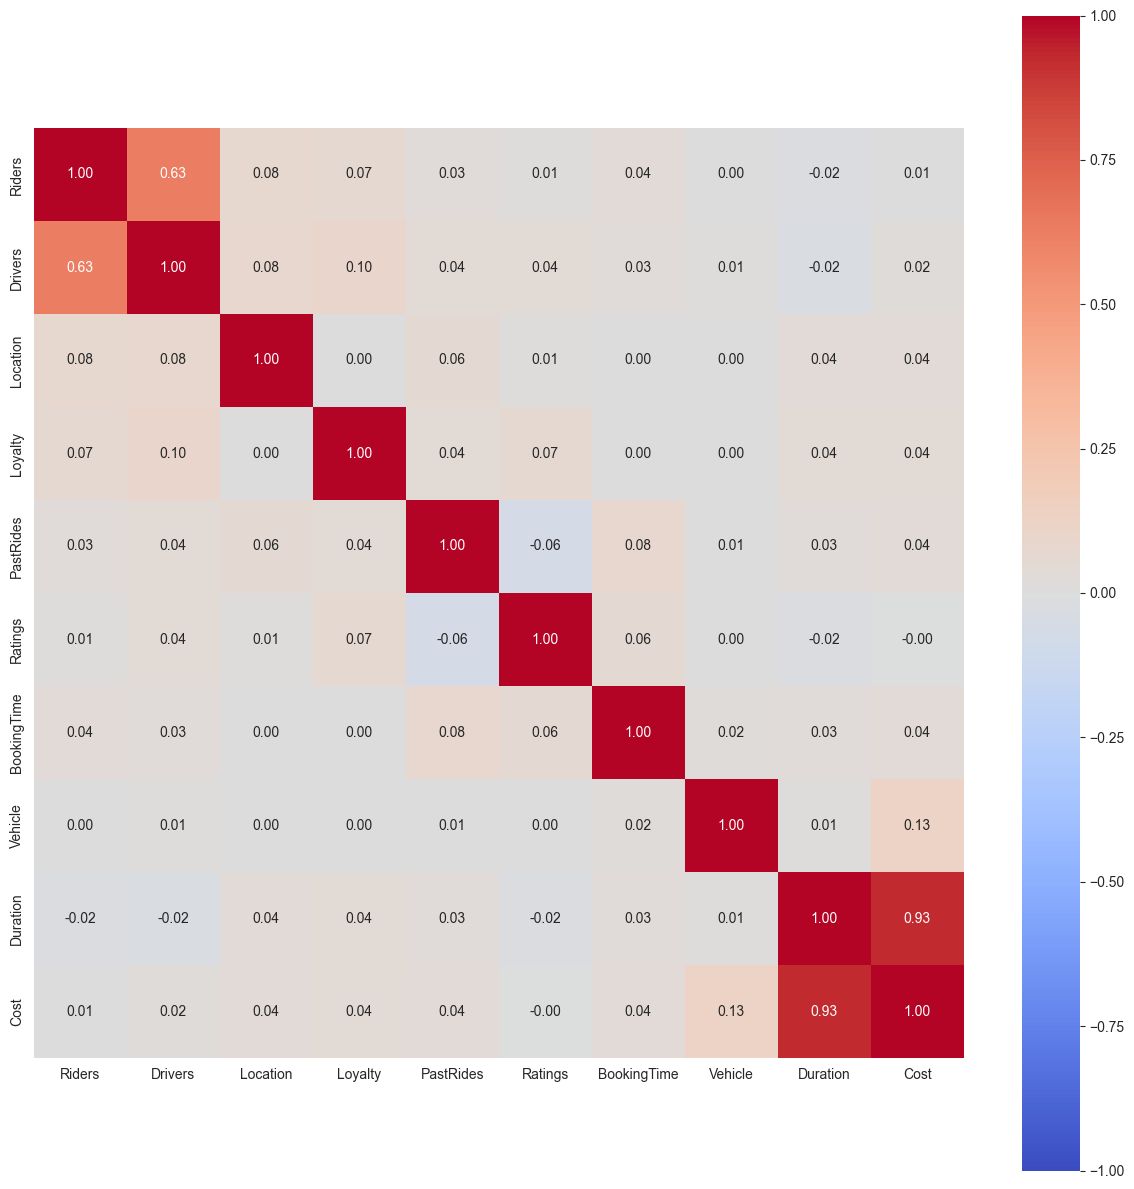

{'corr':                Riders   Drivers  Location   Loyalty  PastRides   Ratings  \
 Riders       1.000000  0.627016  0.075671  0.068983   0.029265  0.008572   
 Drivers      0.627016  1.000000  0.083443  0.098604   0.039660  0.041204   
 Location     0.075671  0.083443  1.000000  0.000000   0.055912  0.014508   
 Loyalty      0.068983  0.098604  0.000000  1.000000   0.041049  0.067979   
 PastRides    0.029265  0.039660  0.055912  0.041049   1.000000 -0.064734   
 Ratings      0.008572  0.041204  0.014508  0.067979  -0.064734  1.000000   
 BookingTime  0.036179  0.027756  0.000000  0.000000   0.083151  0.056488   
 Vehicle      0.002635  0.014845  0.000000  0.000000   0.005615  0.002523   
 Duration    -0.015856 -0.024418  0.036065  0.040724   0.030679 -0.016968   
 Cost         0.005826  0.017082  0.036418  0.040513   0.035859 -0.001063   
 
              BookingTime   Vehicle  Duration      Cost  
 Riders          0.036179  0.002635 -0.015856  0.005826  
 Drivers         0.027756  

In [78]:


# Time for correlation plot. Since we have mix of numerical and categorical variables,
# standard data.corr() won't work here. We will use dython.nominal.associations instead.
dython.nominal.associations(src, plot=True, cmap='coolwarm')

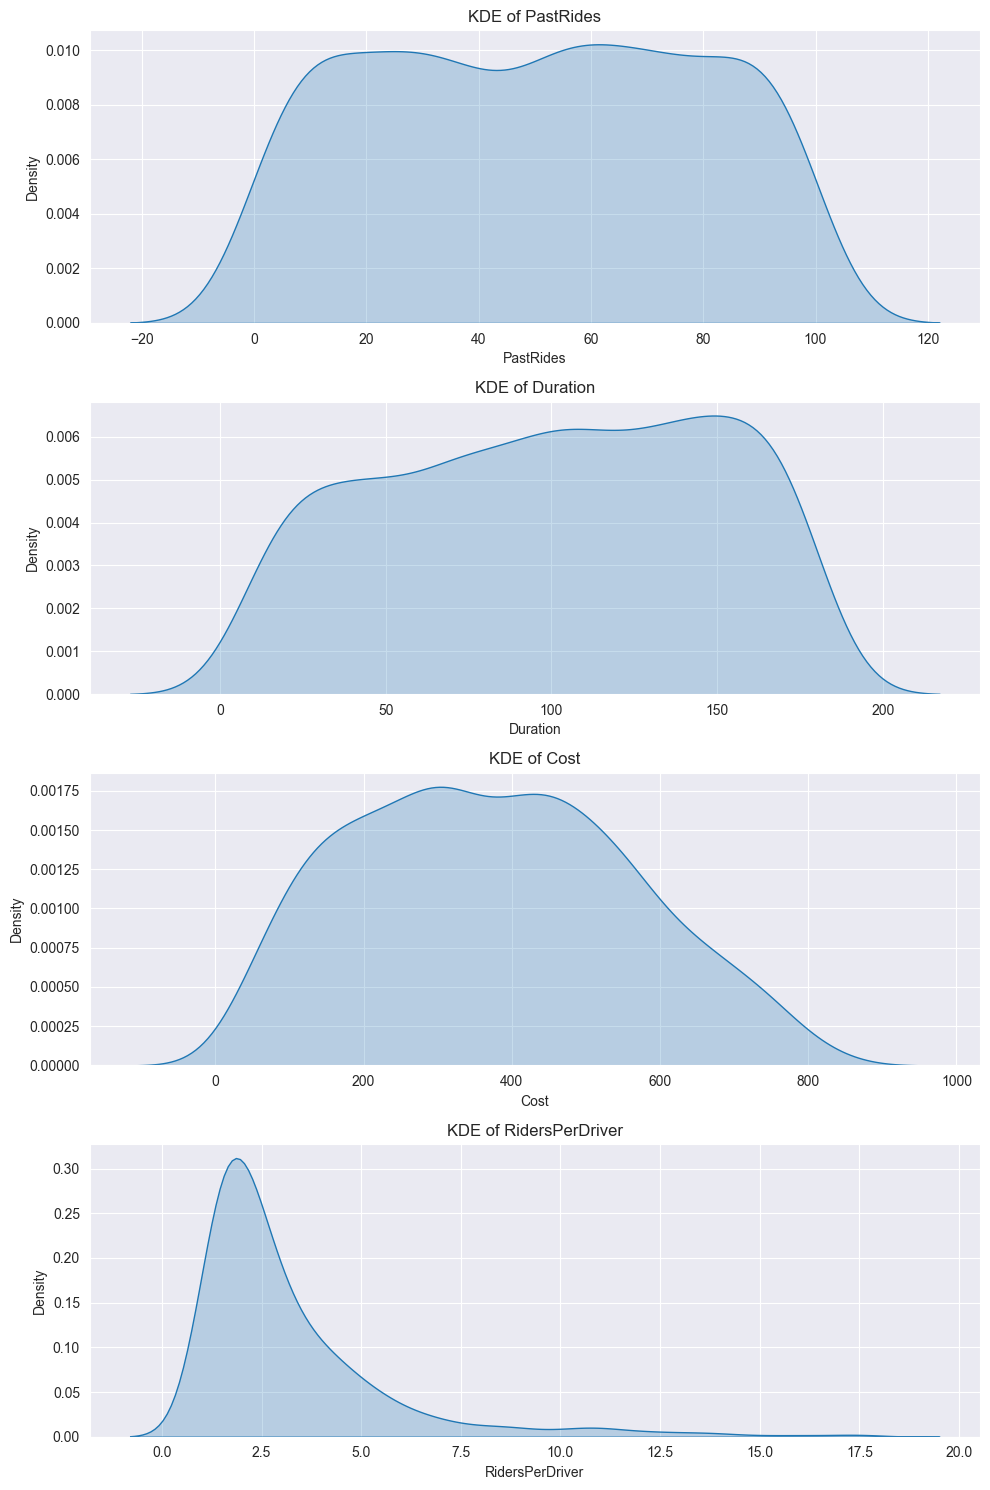

In [79]:
src['RidersPerDriver'] = pd.DataFrame(src['Riders'] / src['Drivers'],
                                      columns=['RidersPerDriver'])
src.drop(columns=['Riders', 'Drivers', 'Ratings'], inplace=True)

# Let's see distributions of numerical columns. We'll use KDE plots for this.
numerical_columns = src.select_dtypes(include=['float64', 'int']).columns
# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 15))
for col, ax in zip(numerical_columns, axes):
    sns.kdeplot(data=src, x=col, ax=ax, fill=True)
    ax.set_title(f'KDE of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

In [80]:
# Duration and Cost have very high correlation (0.93). We will do PCA on these components.
scaler = StandardScaler()
src[['Duration', 'Cost']] = scaler.fit_transform(src[['Duration', 'Cost']])
pca = PCA(n_components=1)
pca_results = pca.fit_transform(src[['Duration', 'Cost']])
src.drop(columns=['Duration', 'Cost'], inplace=True)
src['DurationCostPCA'] = pca_results[:, 0]

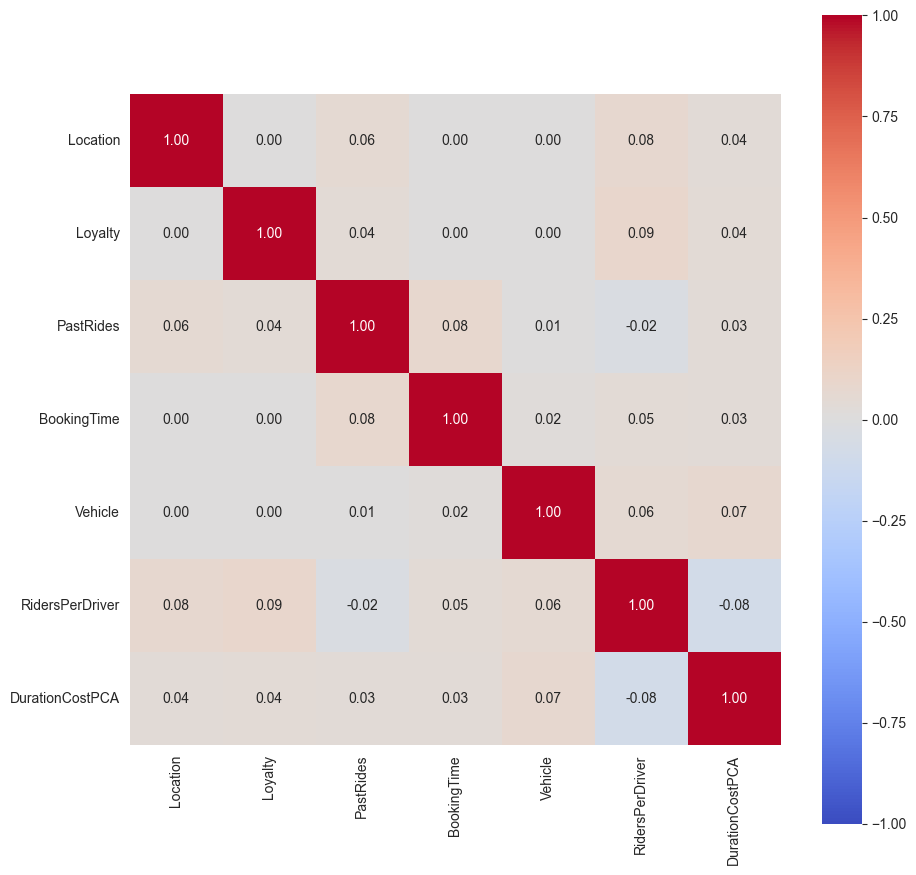

In [81]:
dython.nominal.associations(src, plot=True, cmap='coolwarm')
plt.show()

In [82]:
src['Loyalty'] = src['Loyalty'].map({
    'Regular': -1,
    'Silver': 0,
    'Gold': 1
}).astype(int)

In [83]:
label_encoder = LabelEncoder()
categorical_columns = src.select_dtypes(include=['object']).columns.values
for col in categorical_columns:
    src[col] = LabelEncoder().fit_transform(src[col])

In [84]:
import xgboost

In [85]:
xgb_model = xgboost.XGBRegressor()
feature_names = np.array(src.drop(columns=['DurationCostPCA']).columns)
X = src.drop(columns=['DurationCostPCA']).to_numpy()
y = src['DurationCostPCA'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [86]:
y_pred = xgb_model.predict(X_test)
score = xgb_model.score(X_test, y_test)
print("R squared: ",score)

for name, importance in zip(feature_names, xgb_model.feature_importances_):
    print(f'Feature: {name}, Importance: {importance}')

R squared:  -0.3727785176823666
Feature: Location, Importance: 0.12400905042886734
Feature: Loyalty, Importance: 0.1127442792057991
Feature: PastRides, Importance: 0.20518046617507935
Feature: BookingTime, Importance: 0.16497960686683655
Feature: Vehicle, Importance: 0.1673242300748825
Feature: RidersPerDriver, Importance: 0.22576238214969635


In [87]:
from sklearn.metrics import mean_squared_error
import numpy as np
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)


1.6648114062144803


In [88]:
import optuna
from optuna.pruners import HyperbandPruner
def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    }

    # DMatrix for Cross Validation
    dtrain = xgboost.DMatrix(X, label=y)

    # Perform cross-validation
    cv_results = xgboost.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=50,
        metrics="rmse",
        seed=42
    )

    # Extract the best score
    best_rmse = cv_results['test-rmse-mean'].min()
    return best_rmse

# Start Optuna Study
study = optuna.create_study(direction='minimize', pruner=HyperbandPruner(
    min_resource=1, max_resource=100, reduction_factor=3
))
study.optimize(objective, n_trials=100, timeout=300)

print('Best trial parameters: ', study.best_trial.params)
print('Best RMSE: ', study.best_value)

[I 2024-12-07 10:15:20,327] A new study created in memory with name: no-name-57fc6340-ae06-4f2b-bd7c-dc5516422219
C:\Program Files\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[10:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.


[I 2024-12-07 10:15:20,438] Trial 0 finished with value: 1.3867811207983842 and parameters: {'n_estimators': 996, 'max_depth': 6, 'learning_rate': 0.11151396721206613, 'subsample': 0.5540044202027112, 'gamma': 7.114062741134188, 'reg_alpha': 4.11305259284258}. Best is trial 0 with value: 1.3867811207983842.
[I 2024-12-07 10:15:20,541] Trial 1 finished with value: 1.3918088946221425 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.20969822823652678, 'subsample': 0.7367548930673344, 'gamma': 2.4388930874029513, 'reg_alpha': 0.9659955829174849}. Best is trial 0 with va

Best trial parameters:  {'n_estimators': 773, 'max_depth': 3, 'learning_rate': 0.29383703928051963, 'subsample': 0.9883523430357528, 'gamma': 3.547633126353716, 'reg_alpha': 3.433322442011188}
Best RMSE:  1.379062149717361


In [89]:
import optuna.visualization as optuna_plots
optuna.visualization.plot_param_importances(study)

Zgodnie z przewidywaniami, Learning rate ma zdecydowanie największy wpływ

In [90]:
optuna_plots.plot_optimization_history(study)

In [91]:
best_params = study.best_trial.params
xgb_optimal = xgboost.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha']
)

xgb_optimal.fit(X_train, y_train)
xgb_optimal.predict(X_test)
xgb_optimal.score(X_test, y_train)

print('optimized feature importances: ', xgb_optimal.feature_importances_)
print('original feature importances: ', xgb_model.feature_importances_)

ValueError: Found input variables with inconsistent numbers of samples: [800, 200]

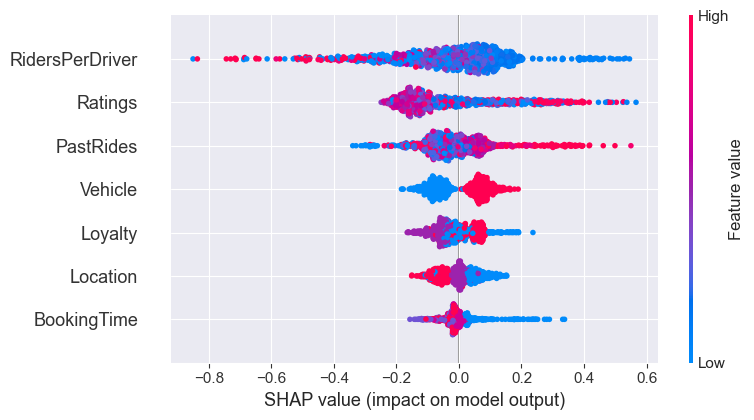

In [67]:
import shap

# Create a SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(xgb_optimal, X)

# Calculate SHAP values for the dataset
shap_values = explainer(X)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

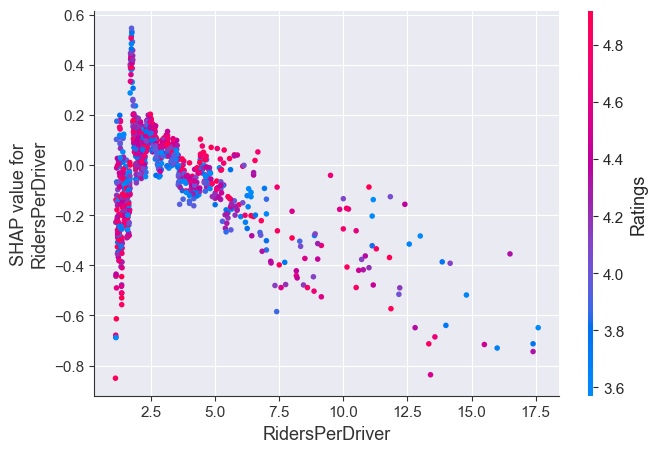

In [68]:
shap.dependence_plot("RidersPerDriver", shap_values.values, X, feature_names=feature_names)

In [69]:
import plotly.express as px
import pandas as pd

# Prepare data for plotting
features = ['Location', 'Loyalty', 'PastRides', 'Ratings', 'BookingTime', 'Vehicle', 'RidersPerDriver']
original_importances = xgb_model.feature_importances_
optimized_importances = xgb_optimal.feature_importances_

# Create a DataFrame for easy plotting
importances_df = pd.DataFrame({
    'Feature': features,
    'Original Importance': original_importances,
    'Optimized Importance': optimized_importances
})

# Plotting using plotly
fig = px.bar(importances_df, x='Feature', y=['Original Importance', 'Optimized Importance'],
             title='Feature Importances: Original vs Optimized',
             labels={'value': 'Importance', 'Feature': 'Feature'},
             barmode='group')

fig.show()

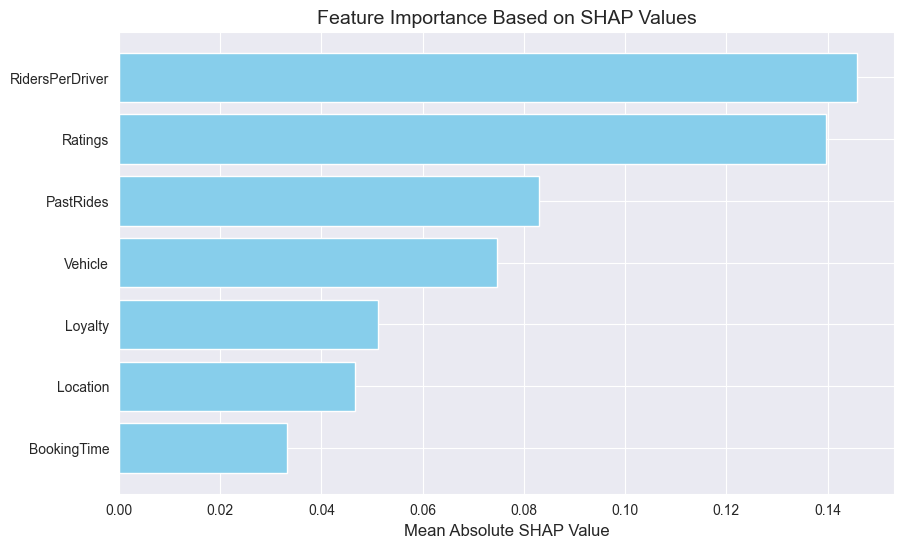

           Feature  Importance
6  RidersPerDriver    0.145841
3          Ratings    0.139794
2        PastRides    0.082905
5          Vehicle    0.074749
1          Loyalty    0.051194
0         Location    0.046543
4      BookingTime    0.033118


In [70]:
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Sort features by importance
feature_importance = pd.DataFrame(list(zip(feature_names, shap_importance)), columns=['Feature', 'Importance'])

feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.title('Feature Importance Based on SHAP Values', fontsize=14)
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
print(feature_importance)

# Exploring additional model improvement possibilities
Let's try to improve our model. We will try to find to determine destination of ride (is it going to urban area? or rual?) Such prediction would be helpful when optimizing usage of cabs- penalizing when he is going for a long ride to rual area, and lowering a rate when coming back to town etc.


In [71]:
from sklearn.metrics import accuracy_score

lb_encoder = LabelEncoder()
label_encoder.fit(categorical_columns)
def objective(trial):
    # Suggest hyperparameter values
    param = {
        'objective': 'multi:softmax',
        'num_class': len(label_encoder.classes_),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'eval_metric': 'mlogloss'
    }

    # Create and train the model
    model = xgboost.XGBClassifier(**param)
    model.fit(X_train, y_train)

    # Predict and get accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Use the pruner based on the trial step and accuracy score
    trial.report(accuracy, step=1)

    # Implement early stopping
    if trial.should_prune():
        raise optuna.TrialPruned()

    return accuracy

study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())
study.optimize(objective, n_trials=100, timeout=300)


[I 2024-12-07 10:03:48,560] A new study created in memory with name: no-name-8de07cf2-8590-4c46-8133-4e5a50a63dcf
[W 2024-12-07 10:03:48,568] Trial 0 failed with parameters: {'max_depth': 7, 'n_estimators': 263, 'learning_rate': 0.1461377193335399, 'subsample': 0.5107582979165883, 'colsample_bytree': 0.6303732878177792, 'gamma': 0.5389178971613162} because of the following error: ValueError('Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17\n  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35\n  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53\n  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71\n  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89\n  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107\n 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125\n 126 127 128 129 130 131

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799], got [-2.59892184e+00 -2.57862840e+00 -2.56152802e+00 -2.55264786e+00
 -2.54066617e+00 -2.53395507e+00 -2.52331883e+00 -2.49668015e+00
 -2.48032092e+00 -2.47697838e+00 -2.47131485e+00 -2.46905742e+00
 -2.44638201e+00 -2.42292447e+00 -2.40638838e+00 -2.40502144e+00
 -2.39366698e+00 -2.38990884e+00 -2.38460280e+00 -2.38304102e+00
 -2.38015454e+00 -2.37968411e+00 -2.37278941e+00 -2.37137426e+00
 -2.36990639e+00 -2.34439405e+00 -2.34206735e+00 -2.34165309e+00
 -2.33305062e+00 -2.31527113e+00 -2.31246986e+00 -2.30746784e+00
 -2.29980073e+00 -2.29787813e+00 -2.29538317e+00 -2.29399310e+00
 -2.26827964e+00 -2.24509226e+00 -2.24317104e+00 -2.23637397e+00
 -2.22754741e+00 -2.21748794e+00 -2.21476428e+00 -2.21302568e+00
 -2.21237427e+00 -2.20887961e+00 -2.20792248e+00 -2.18718704e+00
 -2.17727755e+00 -2.16569387e+00 -2.15689771e+00 -2.14668204e+00
 -2.14508172e+00 -2.14276610e+00 -2.13617753e+00 -2.12973492e+00
 -2.12316028e+00 -2.12301858e+00 -2.12104257e+00 -2.08985694e+00
 -2.08980296e+00 -2.08797049e+00 -2.08376899e+00 -2.07721835e+00
 -2.07590123e+00 -2.07001972e+00 -2.06460220e+00 -2.06275791e+00
 -2.06044850e+00 -2.05107162e+00 -2.04475707e+00 -2.04231286e+00
 -2.03382895e+00 -2.03069713e+00 -2.02995592e+00 -2.02480632e+00
 -2.01068978e+00 -2.00340195e+00 -2.00148767e+00 -1.99487835e+00
 -1.99223991e+00 -1.97406035e+00 -1.96700788e+00 -1.94662603e+00
 -1.94499621e+00 -1.93307632e+00 -1.93025731e+00 -1.92854476e+00
 -1.92786073e+00 -1.91450711e+00 -1.90890482e+00 -1.89929730e+00
 -1.88975729e+00 -1.88954782e+00 -1.87541457e+00 -1.87195757e+00
 -1.87028811e+00 -1.86363241e+00 -1.85080092e+00 -1.84893091e+00
 -1.83485474e+00 -1.82679200e+00 -1.82560523e+00 -1.82244906e+00
 -1.81884847e+00 -1.80968204e+00 -1.78739746e+00 -1.76729993e+00
 -1.75749889e+00 -1.74607172e+00 -1.72889841e+00 -1.72563779e+00
 -1.71963563e+00 -1.71715196e+00 -1.70445823e+00 -1.69507037e+00
 -1.69370799e+00 -1.68895511e+00 -1.67944469e+00 -1.67131677e+00
 -1.67065612e+00 -1.66457826e+00 -1.65531690e+00 -1.64771934e+00
 -1.64764306e+00 -1.63382985e+00 -1.62257389e+00 -1.62219322e+00
 -1.60121105e+00 -1.59305081e+00 -1.59108437e+00 -1.57435136e+00
 -1.56710900e+00 -1.56508041e+00 -1.54444321e+00 -1.53179235e+00
 -1.53071293e+00 -1.52776483e+00 -1.52745774e+00 -1.52464981e+00
 -1.52395791e+00 -1.51601893e+00 -1.50367504e+00 -1.49931975e+00
 -1.49859603e+00 -1.49347957e+00 -1.49245008e+00 -1.47186875e+00
 -1.45701411e+00 -1.45394169e+00 -1.45149752e+00 -1.44230235e+00
 -1.43714145e+00 -1.43622425e+00 -1.43384107e+00 -1.43355063e+00
 -1.42589387e+00 -1.42418576e+00 -1.41455518e+00 -1.39721006e+00
 -1.39316170e+00 -1.39299002e+00 -1.38775315e+00 -1.38640661e+00
 -1.38324615e+00 -1.37880383e+00 -1.37679734e+00 -1.36620698e+00
 -1.36383997e+00 -1.36175477e+00 -1.34934741e+00 -1.32493088e+00
 -1.31250410e+00 -1.30921758e+00 -1.30493712e+00 -1.30489363e+00
 -1.29895973e+00 -1.28288735e+00 -1.28275664e+00 -1.28177391e+00
 -1.27944591e+00 -1.27340042e+00 -1.25891965e+00 -1.25719894e+00
 -1.24424451e+00 -1.23907679e+00 -1.23728402e+00 -1.23043872e+00
 -1.21968287e+00 -1.20643648e+00 -1.20577146e+00 -1.20117595e+00
 -1.20093337e+00 -1.18704085e+00 -1.16893894e+00 -1.16113105e+00
 -1.16030290e+00 -1.15683978e+00 -1.14173137e+00 -1.14060193e+00
 -1.13969682e+00 -1.13568534e+00 -1.12919470e+00 -1.12630285e+00
 -1.10872128e+00 -1.10590402e+00 -1.10047040e+00 -1.09879238e+00
 -1.09772219e+00 -1.07150702e+00 -1.06738297e+00 -1.04991597e+00
 -1.04573625e+00 -1.02965343e+00 -1.02709855e+00 -1.02195756e+00
 -1.01497259e+00 -1.00330096e+00 -9.99725586e-01 -9.94018386e-01
 -9.91033516e-01 -9.87616237e-01 -9.84560731e-01 -9.81960905e-01
 -9.80115344e-01 -9.69614063e-01 -9.62586280e-01 -9.49852744e-01
 -9.43612880e-01 -9.43187986e-01 -9.42772198e-01 -9.31973294e-01
 -9.28375037e-01 -9.13212915e-01 -9.07180623e-01 -9.03635978e-01
 -9.03293958e-01 -9.02861923e-01 -8.95721754e-01 -8.89799461e-01
 -8.82196987e-01 -8.75556914e-01 -8.75202303e-01 -8.73672782e-01
 -8.71124092e-01 -8.58482626e-01 -8.52668563e-01 -8.48297625e-01
 -8.46837691e-01 -8.43954004e-01 -8.32116589e-01 -8.28535125e-01
 -8.19501205e-01 -8.15927335e-01 -8.15690999e-01 -8.07083892e-01
 -8.06790481e-01 -8.04225280e-01 -8.02824234e-01 -8.02374861e-01
 -8.02348526e-01 -7.97756916e-01 -7.96752088e-01 -7.95003820e-01
 -7.94985662e-01 -7.92773452e-01 -7.67873583e-01 -7.54277724e-01
 -7.53339617e-01 -7.30979985e-01 -7.27820681e-01 -7.26204436e-01
 -7.22739152e-01 -7.22458477e-01 -7.20928216e-01 -7.13073319e-01
 -7.02681668e-01 -6.99344250e-01 -6.96047858e-01 -6.84013659e-01
 -6.74343830e-01 -6.74273673e-01 -6.61478335e-01 -6.61156662e-01
 -6.58488667e-01 -6.44699776e-01 -6.42223479e-01 -6.40221745e-01
 -6.37272309e-01 -6.33006623e-01 -6.27826009e-01 -6.18997246e-01
 -6.05960852e-01 -5.96019843e-01 -5.84405516e-01 -5.80153940e-01
 -5.69373132e-01 -5.67596968e-01 -5.52946978e-01 -5.46393448e-01
 -5.46299143e-01 -5.43202122e-01 -5.31797002e-01 -5.28028557e-01
 -5.26953170e-01 -5.22704245e-01 -5.20293648e-01 -5.09681506e-01
 -5.03719711e-01 -5.00849975e-01 -4.98037924e-01 -4.96023895e-01
 -4.93501436e-01 -4.88595271e-01 -4.84698454e-01 -4.79685512e-01
 -4.71533086e-01 -4.57780381e-01 -4.52716543e-01 -4.51302928e-01
 -4.50862097e-01 -4.45976737e-01 -4.36878950e-01 -4.23566326e-01
 -4.03127078e-01 -4.02575501e-01 -3.94320527e-01 -3.92842561e-01
 -3.91099650e-01 -3.85211654e-01 -3.82663701e-01 -3.66062634e-01
 -3.62627597e-01 -3.59100043e-01 -3.52552945e-01 -3.47192709e-01
 -3.45743495e-01 -3.45698381e-01 -3.42758658e-01 -3.40965807e-01
 -3.32012175e-01 -3.26431001e-01 -3.24981383e-01 -3.17640346e-01
 -3.12807708e-01 -3.04404900e-01 -3.00001385e-01 -2.99306861e-01
 -2.97952119e-01 -2.87069387e-01 -2.82687586e-01 -2.78646076e-01
 -2.77087671e-01 -2.69756634e-01 -2.67637903e-01 -2.67375926e-01
 -2.64588064e-01 -2.40674946e-01 -2.34447500e-01 -2.15485057e-01
 -2.11609059e-01 -2.00541615e-01 -1.98727863e-01 -1.96401058e-01
 -1.94714586e-01 -1.93901053e-01 -1.88393652e-01 -1.87554918e-01
 -1.81569360e-01 -1.67260264e-01 -1.64559570e-01 -1.61207114e-01
 -1.53195068e-01 -1.46787090e-01 -1.41649612e-01 -1.36956932e-01
 -1.29669735e-01 -1.25911079e-01 -1.25413200e-01 -1.21518434e-01
 -1.20988696e-01 -1.07770127e-01 -9.46087590e-02 -9.37141861e-02
 -9.30142553e-02 -9.05722886e-02 -7.91198662e-02 -7.63125822e-02
 -7.58388286e-02 -5.87333607e-02 -4.67055384e-02 -4.46152551e-02
 -3.76395726e-02 -3.45217574e-02 -1.47136632e-02 -9.48170087e-03
 -6.70796583e-03  1.08460448e-03  5.91152671e-03  1.26453790e-02
  1.28800829e-02  1.64080530e-02  1.87973547e-02  1.92197349e-02
  1.92866218e-02  2.42674108e-02  2.81067276e-02  3.95272907e-02
  4.36341555e-02  4.36366649e-02  4.70115889e-02  5.63073602e-02
  5.97170544e-02  6.24934365e-02  8.03225817e-02  8.32433245e-02
  8.47486925e-02  8.66873871e-02  9.38785937e-02  1.07918071e-01
  1.14841968e-01  1.19027309e-01  1.28759968e-01  1.35765802e-01
  1.36548907e-01  1.39812900e-01  1.42943215e-01  1.43831830e-01
  1.45344688e-01  1.48862394e-01  1.59972162e-01  1.67646747e-01
  1.76676280e-01  1.79269974e-01  1.82405762e-01  1.89247361e-01
  1.89705254e-01  2.08898754e-01  2.18714059e-01  2.21751704e-01
  2.22409240e-01  2.27166122e-01  2.35896403e-01  2.46614794e-01
  2.49128632e-01  2.53137425e-01  2.56953721e-01  2.83107474e-01
  2.85533782e-01  2.85802471e-01  2.96105737e-01  2.99461604e-01
  3.00095679e-01  3.05052157e-01  3.11624966e-01  3.14665009e-01
  3.23828352e-01  3.32576321e-01  3.62925166e-01  3.64816585e-01
  3.69133563e-01  3.71798808e-01  3.75496423e-01  3.75525864e-01
  3.77602937e-01  3.86272664e-01  3.88033060e-01  3.89903214e-01
  3.92322629e-01  3.93634443e-01  4.08964479e-01  4.17322258e-01
  4.19769785e-01  4.20194895e-01  4.26610387e-01  4.26683657e-01
  4.29328320e-01  4.41158863e-01  4.42079961e-01  4.44587936e-01
  4.45544008e-01  4.46021180e-01  4.47284802e-01  4.55155709e-01
  4.67360393e-01  4.72319150e-01  4.77025258e-01  4.86752304e-01
  4.88536928e-01  4.94530340e-01  4.96614336e-01  5.06436295e-01
  5.08966284e-01  5.11819077e-01  5.13614637e-01  5.18782883e-01
  5.33637256e-01  5.36868627e-01  5.38047058e-01  5.39359194e-01
  5.52072242e-01  5.59031197e-01  5.62013524e-01  5.64130583e-01
  5.65901719e-01  5.73832860e-01  5.98409749e-01  5.99570163e-01
  5.99681099e-01  6.03082295e-01  6.14545874e-01  6.16513106e-01
  6.21525241e-01  6.22180604e-01  6.31290766e-01  6.35782515e-01
  6.51239959e-01  6.57282866e-01  6.62165265e-01  6.66676395e-01
  6.72738467e-01  6.81575100e-01  6.92760392e-01  6.94962391e-01
  6.97475997e-01  7.10941135e-01  7.13480720e-01  7.33844852e-01
  7.36655474e-01  7.38536058e-01  7.44843483e-01  7.55869975e-01
  7.61770017e-01  7.69677537e-01  7.80496136e-01  7.89593568e-01
  7.89625139e-01  7.90242765e-01  7.98497291e-01  7.99664167e-01
  8.00872691e-01  8.02101579e-01  8.11462751e-01  8.11743340e-01
  8.25453343e-01  8.34003151e-01  8.56061474e-01  8.60885301e-01
  8.64468524e-01  8.68209949e-01  8.73425227e-01  8.79914641e-01
  8.83363606e-01  8.88601968e-01  8.91424356e-01  8.93177295e-01
  8.94704470e-01  8.96110956e-01  9.14210638e-01  9.16410716e-01
  9.19843121e-01  9.20975657e-01  9.22632967e-01  9.24559975e-01
  9.27546080e-01  9.38713765e-01  9.43972328e-01  9.49151724e-01
  9.50340934e-01  9.54906395e-01  9.63876340e-01  9.66028764e-01
  9.76945990e-01  9.88209242e-01  9.93420990e-01  9.93988344e-01
  1.00160554e+00  1.02381317e+00  1.02606622e+00  1.03155335e+00
  1.03374989e+00  1.05070268e+00  1.05385306e+00  1.05496737e+00
  1.06038767e+00  1.06439360e+00  1.06513325e+00  1.06515055e+00
  1.07085394e+00  1.07315863e+00  1.07676666e+00  1.07910807e+00
  1.08013295e+00  1.08379601e+00  1.09119161e+00  1.10214921e+00
  1.10546122e+00  1.10905512e+00  1.11343043e+00  1.11503069e+00
  1.11698162e+00  1.13109229e+00  1.15367115e+00  1.16045945e+00
  1.16268589e+00  1.17853546e+00  1.18091310e+00  1.18527176e+00
  1.19401285e+00  1.20331122e+00  1.20407097e+00  1.20913860e+00
  1.21169461e+00  1.21886607e+00  1.22640071e+00  1.22926823e+00
  1.23143203e+00  1.23198277e+00  1.23954227e+00  1.23983413e+00
  1.24001112e+00  1.24069021e+00  1.25536100e+00  1.25614526e+00
  1.26141601e+00  1.26201506e+00  1.26932632e+00  1.26934431e+00
  1.26973729e+00  1.27118762e+00  1.27199400e+00  1.27283822e+00
  1.27381148e+00  1.27818693e+00  1.28033361e+00  1.28340106e+00
  1.28386067e+00  1.28461779e+00  1.29711978e+00  1.30343575e+00
  1.31413765e+00  1.32757698e+00  1.33696853e+00  1.34069938e+00
  1.34161128e+00  1.36059936e+00  1.36451097e+00  1.36689852e+00
  1.36962655e+00  1.37254200e+00  1.37274185e+00  1.37897835e+00
  1.38778270e+00  1.39364596e+00  1.39760295e+00  1.40222459e+00
  1.41309788e+00  1.42185711e+00  1.42636393e+00  1.43000675e+00
  1.43388841e+00  1.43855738e+00  1.44117827e+00  1.44362441e+00
  1.45415903e+00  1.45477015e+00  1.46536033e+00  1.47212882e+00
  1.47908167e+00  1.48714727e+00  1.49414471e+00  1.49504823e+00
  1.49677134e+00  1.50083780e+00  1.51967255e+00  1.52377419e+00
  1.52549504e+00  1.52595855e+00  1.52692648e+00  1.52818605e+00
  1.54708658e+00  1.56165890e+00  1.56257977e+00  1.57138648e+00
  1.58170177e+00  1.60807335e+00  1.60946984e+00  1.61626238e+00
  1.61799765e+00  1.62373411e+00  1.63633193e+00  1.64094464e+00
  1.64113880e+00  1.64507790e+00  1.66119549e+00  1.66526143e+00
  1.67976556e+00  1.68533775e+00  1.68670913e+00  1.68674262e+00
  1.70505761e+00  1.70527464e+00  1.70893246e+00  1.70988376e+00
  1.73062992e+00  1.73117823e+00  1.73890192e+00  1.74411514e+00
  1.75031647e+00  1.75826385e+00  1.75955015e+00  1.76268318e+00
  1.77237390e+00  1.78059249e+00  1.79305971e+00  1.79885552e+00
  1.80062699e+00  1.80895561e+00  1.81224742e+00  1.82336158e+00
  1.82778667e+00  1.82986228e+00  1.83590188e+00  1.83866514e+00
  1.84114301e+00  1.84223810e+00  1.84246070e+00  1.85230965e+00
  1.85255269e+00  1.88766322e+00  1.88804535e+00  1.89126559e+00
  1.89934698e+00  1.90645336e+00  1.90766489e+00  1.92009237e+00
  1.93059814e+00  1.95139558e+00  1.95221873e+00  1.95291755e+00
  1.95474013e+00  1.96990573e+00  1.98146306e+00  1.99767241e+00
  2.00131190e+00  2.00146730e+00  2.01140377e+00  2.02408146e+00
  2.02936517e+00  2.03886692e+00  2.03960034e+00  2.04298975e+00
  2.04695604e+00  2.05444645e+00  2.06579282e+00  2.09204007e+00
  2.10300264e+00  2.11180243e+00  2.11507661e+00  2.11914945e+00
  2.13985183e+00  2.14978063e+00  2.16398051e+00  2.19353082e+00
  2.19998113e+00  2.24012591e+00  2.27612181e+00  2.29974827e+00
  2.30530722e+00  2.32104785e+00  2.33945828e+00  2.34171004e+00
  2.36002493e+00  2.36810654e+00  2.36958323e+00  2.37585873e+00
  2.38779554e+00  2.39021574e+00  2.39556919e+00  2.39857529e+00
  2.39940497e+00  2.42846332e+00  2.44320814e+00  2.44404758e+00
  2.49374457e+00  2.49456247e+00  2.50968630e+00  2.51262470e+00
  2.54007618e+00  2.54724973e+00  2.55859861e+00  2.58249556e+00
  2.60591819e+00  2.64238263e+00  2.65273420e+00  2.68066580e+00
  2.71241135e+00  2.73717258e+00  2.82710296e+00  2.87966619e+00]